In [19]:
# Importing Data and then transforming it

#importing libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib ipympl

# importing Data
ft_sensor_data_orig = pd.read_csv('Trials_Folder/ft_bigblue_ecoflex_random.csv')
psoc_data_orig = pd.read_csv('Trials_Folder/ps_bigblue_ecoflex_random.csv')
psoc_data = psoc_data_orig.copy()
ft_sensor_data = ft_sensor_data_orig.copy()

# Transforming Data

#### fix the timestamps #############

# Identify the first column (assumed to be timestamps)
col0 = psoc_data.columns[0]

# Ensure numeric dtype
psoc_data[col0] = pd.to_numeric(psoc_data[col0], errors='coerce')

# Add 10000 to each negative element in the first column
psoc_data.loc[psoc_data[col0] < 0, col0] += 10000

# Accumulate the column in an "accumulation-esque" fashion (running sum)
psoc_data[col0] = psoc_data[col0].cumsum() / 10000 # 10 khz clock

##### Creating new Super Array #########

# Create an n x 17 array: column 0 = timestamp, columns 1-16 = channels (8*mode + pin)
n = len(psoc_data)
psoc_matrix = np.full((n, 17), np.nan, dtype=float)

# Fill timestamp column (already processed above)
psoc_matrix[:, 0] = psoc_data[col0].values 

# Assume the incoming columns are in positions 1 (mode), 2 (pin), 3 (value)
mode_col = psoc_data.columns[1]
pin_col = psoc_data.columns[2]
val_col  = psoc_data.columns[3]

# Convert to numeric arrays
modes = pd.to_numeric(psoc_data[mode_col], errors='coerce').to_numpy(dtype=float)
pins  = pd.to_numeric(psoc_data[pin_col],  errors='coerce').to_numpy(dtype=float)
vals  = pd.to_numeric(psoc_data[val_col],  errors='coerce').to_numpy(dtype=float)

# Compute channel indices and guard against invalid entries
indices = 8 * modes + pins  # expected range: 0..15
valid = np.isfinite(indices) & (indices >= 0) & (indices < 16) & np.isfinite(vals)

rows = np.nonzero(valid)[0]
cols = indices[valid].astype(int) + 1  # +1 because column 0 is timestamp

# Populate matrix
psoc_matrix[rows, cols] = vals[valid]

###### interpolation ##########

# Convert to DataFrame for easier manipulation
col_names = ['timestamp'] + [f'ch{i}' for i in range(1, 17)]
df_psoc = pd.DataFrame(psoc_matrix, columns=col_names)

# Use pandas interpolate() column-wise (treat exact zeros as missing)

# Treat exact 0.0 as missing for sensor columns (do not touch timestamp)
sensor_cols = col_names[1:]
df_psoc[sensor_cols] = df_psoc[sensor_cols].replace(0.0, np.nan)

# Interpolate column-wise. 'linear' uses row order; limit_area='inside' avoids extrapolation.
df_psoc.interpolate(method='linear', axis=0, limit_area='inside', inplace=True)

# Replace any remaining NaNs with 0.0 to keep the matrix numeric
df_psoc.fillna(0.0, inplace=True)

##### Biasing ##########
# Subtract the first non-zero (finite) element from each channel column (ch1..ch16)
sensor_cols = df_psoc.columns[1:]  # ch1..ch16
for col in sensor_cols:
    col_ser = df_psoc[col]
    nonzero_mask = col_ser.notna() & (col_ser != 0)
    if nonzero_mask.any():
        first_val = col_ser.loc[nonzero_mask].iloc[0]
        # subtract from all finite values in the column
        finite_mask = col_ser.notna()
        df_psoc.loc[finite_mask, col] = df_psoc.loc[finite_mask, col] - first_val

##### gets rid of first and last 16 samples #########
df_psoc = df_psoc.iloc[16:-16].reset_index(drop=True)
psoc_data = df_psoc.copy()

##### Normalize timestamps by making them relative to start time #########
ft_start_time = ft_sensor_data['timestamp'].iloc[0]

# use the processed PSOC dataframe (df_psoc) which contains 'timestamp'

psoc_start_time = psoc_data['timestamp'].iloc[0]

# Modify the timestamp columns in place
ft_sensor_data['timestamp'] = ft_sensor_data['timestamp'] - ft_start_time
psoc_data['timestamp'] = (psoc_data['timestamp'] - psoc_start_time) 
#34.3




FT change time: 1.4145341999999985
PSOC change time: 2.0218000000000003
offset_time (set to PSOC if available) = -0.6072658000000017


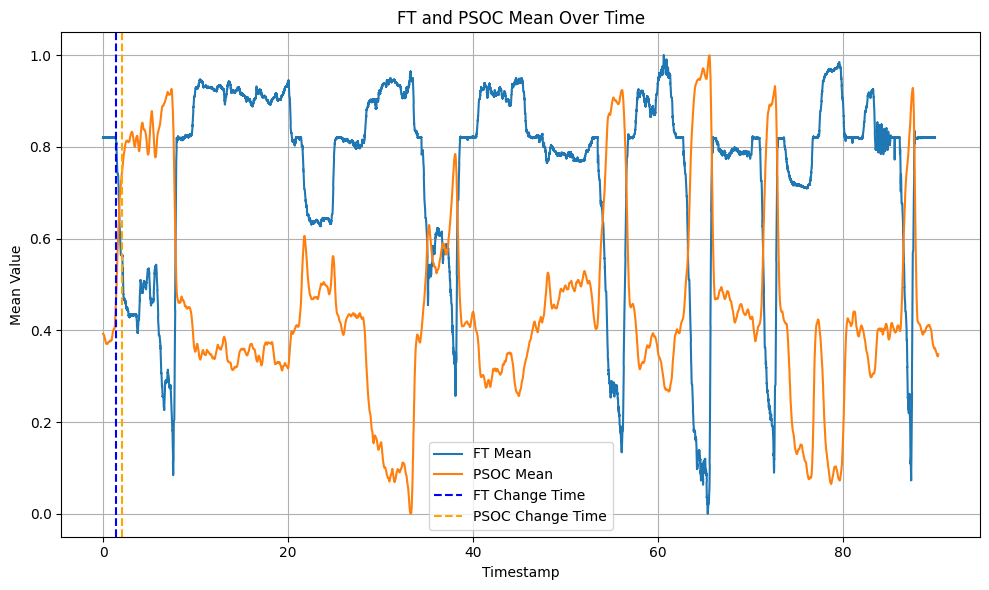

In [20]:
#### Synchronize Data #########

# Finds the time where We start applying force:
# make copies

ft_copy = ft_sensor_data.copy()
psoc_copy = psoc_data.copy()

# compute row-wise average excluding timestamp
ft_mean = ft_copy.drop(columns=['timestamp']).mean(axis=1).to_numpy()
psoc_mean = psoc_copy.drop(columns=['timestamp']).mean(axis=1).to_numpy()

# Normalize both datasets to 0-1 range for fair comparison
ft_mean = (ft_mean - ft_mean.min()) / (ft_mean.max() - ft_mean.min())
psoc_mean = (psoc_mean - psoc_mean.min()) / (psoc_mean.max() - psoc_mean.min())

ft_times = ft_copy['timestamp'].to_numpy()
psoc_times = psoc_copy['timestamp'].to_numpy()

def find_step_time(times, values, threshold=0.1, window_size=3):
    """
        Find the first time where values change by more than threshold
        within a window of 'persistence' samples.
        
        Args:
            times: array of timestamps
            values: array of values
            threshold: minimum change to detect
            window_size: number of samples to look ahead
        
        Returns:
            timestamp where step occurs, or None if no step found
    """
    starting_i = 0
    for i in range(len(values) - window_size):
        if abs(values[i + window_size] - values[i]) > threshold:
            starting_i = i
            break

    # Find the index with the biggest difference in the window
    max_diff = 0
    max_diff_idx = starting_i
    for j in range(starting_i, min(starting_i + window_size + 1, len(values))):
        diff = abs(values[j] - values[starting_i])
        if diff > max_diff:
            max_diff = diff
            max_diff_idx = j
    
    return times[max_diff_idx] if max_diff_idx < len(times) else None
    

ft_change_time = find_step_time(ft_times, ft_mean, threshold=0.0075, window_size=500)
psoc_change_time = find_step_time(psoc_times, psoc_mean, threshold=0.05, window_size=500)

#### Plots to see if you like the synchronization #########
# use PSOC offset as primary if available, otherwise fall back to FT
offset_time = ft_change_time - psoc_change_time 
print(f"FT change time: {ft_change_time}")
print(f"PSOC change time: {psoc_change_time}")
print(f"offset_time (set to PSOC if available) = {offset_time}")

# Plot FT mean
plt.figure(figsize=(10, 6))
plt.plot(ft_times, ft_mean, label='FT Mean', linewidth=1.5)
plt.plot(psoc_times, psoc_mean, label='PSOC Mean', linewidth=1.5)

# Add vertical lines showing where changes occur
if ft_change_time is not None:
    plt.axvline(ft_change_time, color='blue', linestyle='--', label='FT Change Time')
if psoc_change_time is not None:
    plt.axvline(psoc_change_time, color='orange', linestyle='--', label='PSOC Change Time')

plt.title('FT and PSOC Mean Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Mean Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
#once you like where the lines fall, you can apply the offset to the data: 
psoc_data['timestamp'] = (psoc_data['timestamp'] + offset_time)


# Map PSOC data to FT sensor data (6 outputs) by finding closest timestamps
# PSOC inputs: all sensor columns except timestamp
# FT outputs: fx, fy, fz, tx, ty, tz

# For each PSOC timestamp, find the closest FT sensor timestamp
from scipy.spatial import KDTree

# Create a KDTree for efficient nearest neighbor search
ft_timestamps = ft_sensor_data['timestamp'].values.reshape(-1, 1)
psoc_timestamps = psoc_data['timestamp'].values.reshape(-1, 1)

tree = KDTree(ft_timestamps)
distances, indices = tree.query(psoc_timestamps)

# Create aligned dataset
# Extract all PSOC input features except timestamp
X = psoc_data.drop('timestamp', axis=1).values

# Extract the corresponding 6 FT sensor outputs using the matched indices
y = ft_sensor_data.iloc[indices][['fx', 'fy', 'fz', 'tx', 'ty', 'tz']].values

print(f"Created aligned dataset:")
print(f"Input features (PSOC): {X.shape} - {X.shape[1]} sensors x {X.shape[0]} samples")
print(f"Output targets (FT): {y.shape} - 6 measurements x {y.shape[0]} samples")
print(f"\nAverage time difference between matched points: {distances.mean()*1000:.3f} ms")
print(f"Max time difference: {distances.max()*1000:.3f} ms")

# Create a DataFrame for easier viewing
aligned_data = pd.DataFrame(X, columns=psoc_data.drop('timestamp', axis=1).columns)
aligned_data[['fx', 'fy', 'fz', 'tx', 'ty', 'tz']] = y
aligned_data['timestamp'] = psoc_data['timestamp'].values

print("\nFirst few rows of aligned data:")
print(aligned_data.head())

# makes a copy of aligned_data in order to not overwrite original
aligned_data_working = aligned_data.copy()


Created aligned dataset:
Input features (PSOC): (22284, 16) - 16 sensors x 22284 samples
Output targets (FT): (22284, 6) - 6 measurements x 22284 samples

Average time difference between matched points: 4.311 ms
Max time difference: 607.266 ms

First few rows of aligned data:
     ch1     ch2     ch3     ch4     ch5    ch6     ch7    ch8     ch9   ch10  \
0 -0.375 -0.1250  0.0625  2.0000  0.9375  0.000 -1.6250 -1.500 -0.6875 -1.250   
1 -0.500 -0.1875  0.1250  1.9375  1.0000  0.000 -1.7500 -1.625 -0.7500 -1.375   
2 -0.625 -0.2500  0.1875  1.8750  1.0625  0.000 -1.8750 -1.750 -0.8125 -1.500   
3 -0.750 -0.3125  0.2500  1.8125  1.1250 -0.125 -2.0000 -1.875 -0.8750 -1.625   
4 -0.875 -0.3750  0.3125  1.7500  1.1875 -0.250 -1.6875 -2.000 -0.9375 -1.750   

   ...   ch14  ch15     ch16        fx        fy        fz        tx  \
0  ... -0.750   0.0  0.12500 -0.018092 -0.055519  0.024945 -0.000055   
1  ... -0.875   0.0  0.15625 -0.018092 -0.055519  0.024945 -0.000055   
2  ... -1.000   0.0 

In [22]:
### normalize data ###
# Normalize working_psoc_data (exclude timestamp column)
main_columns = aligned_data_working.columns[:-1]  # all columns except timestamp
for col in main_columns:
    col_min = aligned_data_working[col].min()
    col_max = aligned_data_working[col].max()
    if col_max != col_min:  # avoid division by zero
        aligned_data_working[col] = (aligned_data_working[col] - col_min) / (col_max - col_min)
    else:
        aligned_data_working[col] = 0.0

print("\nFirst few rows of normalized aligned data:")
print(aligned_data_working.head())




First few rows of normalized aligned data:
        ch1       ch2       ch3       ch4       ch5       ch6       ch7  \
0  0.350962  0.337217  0.459873  0.473282  0.486047  0.436198  0.596169   
1  0.350592  0.337059  0.459975  0.473203  0.486129  0.436198  0.595972   
2  0.350222  0.336902  0.460078  0.473123  0.486212  0.436198  0.595774   
3  0.349852  0.336744  0.460181  0.473044  0.486295  0.436035  0.595577   
4  0.349482  0.336587  0.460283  0.472964  0.486377  0.435872  0.596070   

        ch8       ch9      ch10  ...      ch14      ch15      ch16        fx  \
0  0.679657  0.349004  0.336055  ...  0.435789  0.597156  0.676519  0.409005   
1  0.679491  0.348820  0.335741  ...  0.435626  0.597156  0.676560  0.409005   
2  0.679326  0.348636  0.335427  ...  0.435463  0.597156  0.676602  0.409005   
3  0.679161  0.348451  0.335113  ...  0.435300  0.597156  0.676643  0.409005   
4  0.678996  0.348267  0.334799  ...  0.435137  0.597156  0.676684  0.409005   

         fy        fz   

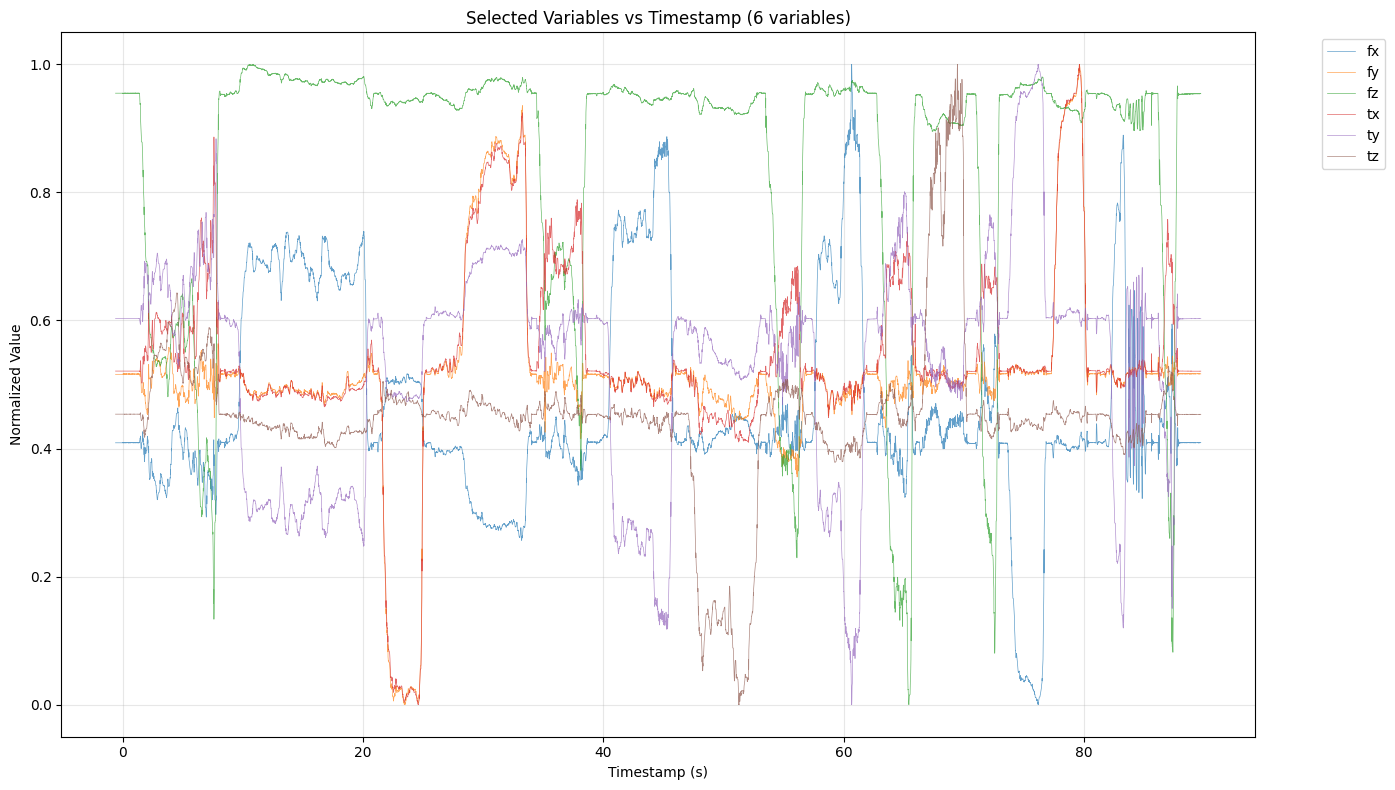

In [23]:
# Plot selected variables from aligned_data_working on the same figure
plt.figure(figsize=(14, 8))

# Get all columns except timestamp
all_columns = [col for col in aligned_data_working.columns if col != 'timestamp']

# Create a mask array: 1 to plot, 0 to hide
# Order: ch1-ch16 (indices 0-15), fx, fy, fz, tx, ty, tz (indices 16-21)

mask = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,   # first 16 channels
                 1,1,1,1,1,1])                      # ft outputs

# Apply mask to select columns
columns_to_plot = [col for col, m in zip(all_columns, mask) if m == 1]

# Plot each selected variable
for col in columns_to_plot:
    plt.plot(aligned_data_working['timestamp'], aligned_data_working[col], linewidth=0.5, label=col, alpha=0.7)

plt.xlabel('Timestamp (s)')
plt.ylabel('Normalized Value')
plt.title(f'Selected Variables vs Timestamp ({len(columns_to_plot)} variables)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [28]:
###### Linear Modeling for un-normalized data #########

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Create 6 separate linear regression models (one for each FT output)
models = {}
predictions = {}
metrics = {}

# FT output labels
ft_labels = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']

# Train a separate model for each FT sensor output
for i, label in enumerate(ft_labels):
    # Create and train the model
    model = LinearRegression()
    model.fit(X, y[:, i])
    
    # Store the model
    models[label] = model
    
    # Make predictions
    y_pred = model.predict(X)
    predictions[label] = y_pred
    
    # Calculate metrics
    r2 = r2_score(y[:, i], y_pred)
    mse = mean_squared_error(y[:, i], y_pred)
    rmse = np.sqrt(mse)
    
    metrics[label] = {
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse
    }
    
    print(f"\n{label} Model:")
    print(f"  R² Score: {r2:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  Coefficients: {model.coef_.round(4)}")
    print(f"  Intercept: {model.intercept_:.6f}")

print("\n" + "="*60)
print("Summary of all models:")
print("="*60)
for label in ft_labels:
    print(f"{label}: R² = {metrics[label]['R²']:.6f}, RMSE = {metrics[label]['RMSE']:.6f}")


fx Model:
  R² Score: 0.765536
  RMSE: 7.731606
  Coefficients: [-0.128  -0.1477  0.3551  0.6029 -0.4489  0.6013 -0.432   0.0543  0.4146
  0.0276 -0.3085 -0.7026  0.2076 -0.3672  0.166   0.2023]
  Intercept: 0.010250

fy Model:
  R² Score: 0.738101
  RMSE: 8.124272
  Coefficients: [-0.5289  0.0337 -0.3866 -0.0397  0.2846  0.0274 -0.1539  0.0681  0.6382
 -0.0962  0.3332  0.1122 -0.4481  0.0561  0.0935 -0.0161]
  Intercept: -0.028814

fz Model:
  R² Score: 0.658118
  RMSE: 31.898297
  Coefficients: [-0.286  -0.3717  0.8023 -0.4744 -0.7564 -0.4459  0.4099  1.0742 -0.6154
  0.8854 -1.1388  0.4726 -0.4829  1.2013 -0.5023 -0.7337]
  Intercept: -1.669563

tx Model:
  R² Score: 0.755974
  RMSE: 0.445253
  Coefficients: [-0.0164  0.0038 -0.0259 -0.007   0.0245  0.0064 -0.0194 -0.0019  0.0274
 -0.0099  0.0238  0.0121 -0.0254 -0.0073  0.0177  0.0024]
  Intercept: -0.002142

ty Model:
  R² Score: 0.768562
  RMSE: 0.469272
  Coefficients: [-0.0017  0.0123 -0.0255 -0.0287  0.0246 -0.0289  0.0258 -0

In [ ]:
###### Linear Modeling for normalized data #########

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Create 6 separate linear regression models (one for each FT output)
models = {}
predictions = {}
metrics = {}

# FT output labels
ft_labels = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']

# Train a separate model for each FT sensor output
for i, label in enumerate(ft_labels):
    # Create and train the model
    model = LinearRegression()
    # the only difference between the normalizedn and un-normalized is that I re-define X and y here
    X = aligned_data_working.drop(columns=['timestamp', 'fx', 'fy', 'fz', 'tx', 'ty', 'tz']).values
    y = aligned_data_working[ft_labels].values
    model.fit(X, y[:, i])
    
    # Store the model
    models[label] = model
    
    # Make predictions
    y_pred = model.predict(X)
    predictions[label] = y_pred
    
    # Calculate metrics
    r2 = r2_score(y[:, i], y_pred)
    mse = mean_squared_error(y[:, i], y_pred)
    rmse = np.sqrt(mse)
    
    metrics[label] = {
        'R²': r2,
        'MSE': mse,
        'RMSE': rmse
    }
    
    print(f"\n{label} Model:")
    print(f"  R² Score: {r2:.6f}")
    print(f"  RMSE: {rmse:.6f}")
    print(f"  Coefficients: {model.coef_.round(4)}")
    print(f"  Intercept: {model.intercept_:.6f}")

print("\n" + "="*60)
print("Summary of all models:")
print("="*60)
for label in ft_labels:
    print(f"{label}: R² = {metrics[label]['R²']:.6f}, RMSE = {metrics[label]['RMSE']:.6f}")


fx Model:
  R² Score: 0.765536
  RMSE: 0.078376
  Coefficients: [-0.4384 -0.5945  2.1925  4.8033 -3.4447  4.6813 -2.7721  0.417   1.4247
  0.1113 -1.9141 -5.6194  1.5913 -2.8551  1.0653  1.5522]
  Intercept: 0.283949

fy Model:
  R² Score: 0.738101
  RMSE: 0.071217
  Coefficients: [-1.567   0.1171 -2.0638 -0.2734  1.8884  0.1842 -0.8539  0.4518  1.8965
 -0.3356  1.7876  0.776  -2.9694  0.3775  0.5189 -0.1067]
  Intercept: 0.607854

fz Model:
  R² Score: 0.658118
  RMSE: 0.120782
  Coefficients: [-0.366  -0.5588  1.8502 -1.4118 -2.1681 -1.2967  0.9824  3.0792 -0.7899
  1.3343 -2.639   1.412  -1.3823  3.4888 -1.2041 -2.1031]
  Intercept: 1.677560

tx Model:
  R² Score: 0.755974
  RMSE: 0.072825
  Coefficients: [-0.9056  0.2491 -2.5795 -0.9047  3.0324  0.8007 -2.0103 -0.2309  1.5194
 -0.6416  2.3805  1.5559 -3.143  -0.9161  1.8374  0.2912]
  Intercept: 0.390564

ty Model:
  R² Score: 0.768562
  RMSE: 0.081269
  Coefficients: [-0.0973  0.8491 -2.6874 -3.9018  3.2284 -3.8457  2.8306 -1.278